# Part I 
## Final Demo - License Plate Bounding Box & Rectifying LP

The model can be downloaded from github: 
https://github.com/Millow02/Koala/raw/refs/heads/ALPR/ALPR/YOLOv8n_TEST/my_project/exp1/weights/best.pt

Use the following command:
wget 'https://github.com/Millow02/Koala/raw/refs/heads/ALPR/ALPR/YOLOv8n_TEST/my_project/exp1/weights/best.pt'

In [3]:
import os
import cv2 
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Image Format for part I,
The image format of the images stored in the rapsbeery pi is 

| Stage | Image Format  |
|--|--|
| License Plate Detection | 640x480 |
| License Plate Detection(Testing) | 640x640 |

Types of classes trained:
- [ ] LP
- [ ] LP, Obstructed 
- [ ] LP, no vehicle


Following shows the format of the image recieved as input to the bounding box program.

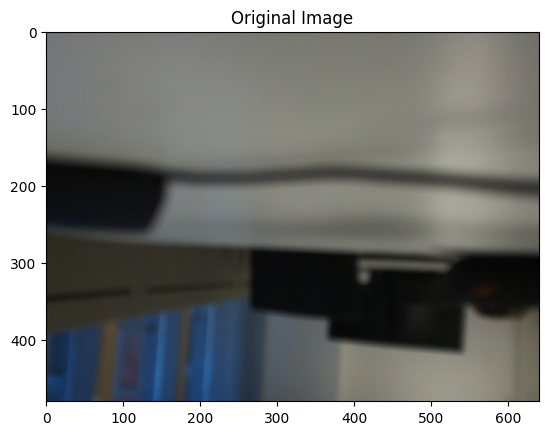

In [4]:
image_640x480 = "raspberry_pi_image.jpg"
image = cv2.imread(image_640x480)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

In [2]:
def crop_image_with_model(model_path, input_dir, session_number, output_dir='cropped_outputs'):
    """
    Processes images using a YOLOv8 model to detect and crop license plates from images.
    
    Args:
        model_path (str): Path to the YOLOv8 model weights (.pt file)
                         The model should be trained to detect license plates with classes:
                         - LP (standard license plate)
                         - LP, Obstructed (partially visible license plate)
                         - LP, no vehicle (license plate without visible vehicle)
        
        input_dir (str): Directory containing the input images to process.
                        Supported formats: .jpg, .jpeg, .png, .bmp
                        Expected input image size: 640x480 or 640x640
        
        output_dir (str, optional): Directory where cropped license plates will be saved.
                                  Defaults to 'cropped_outputs'.
                                  A subdirectory will be created for each processed image.
        
        session_number (int, optional): Identifier for the processing session.
                                      Used to organize outputs from different runs.
    
    Returns:
        None: Results are saved directly to the output directory
    
    Model Details:
        - Architecture: YOLOv8n, YOLOv8n
        - Input Resolution: 640x640, 640x480
        - Confidence Threshold: 0.25
        - IOU Threshold: 0.45
        - Output: Bounding boxes for detected license plates
    """
    # Create the output directory if it does not exist
    output_dir = os.path.join(output_dir, f"session_number_{session_number}")
    os.makedirs(output_dir, exist_ok=True)
    # Load model
    model = YOLO(model_path)

    # Get list of image files in input directory
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(valid_extensions)]
    
    for image_file in image_files:
        # Construct full image path
        image_path = os.path.join(input_dir, image_file)
        
        # Read the image
        image = cv2.imread(image_path)
        
        # Run inference on the image
        results = model.predict(source=image_path, conf=0.25, iou=0.45)
        
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()

            for idx, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cropped_image = image[y1-20:y2+20, x1-20:x2+20]
                # Create output path with filename
                output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_crop_{idx+1}.jpg')
                cv2.imwrite(output_path, cropped_image)
                print(f'Saved cropped image to {output_path}')

#### <u>Testing Directories</u>

| Directory | File Format Types | Images Sizes|
|-----------|------------------|-|
|"D:\\Programming\\COEN490\\testing_area\\test_data\\images\\val"  | .jpg, .jpeg, .png, .bmp |TBA|
| D:\Programming\COEN490\testing_area\train\images | .jpg | 640x640


In [ ]:
testingdir = []
testingdir.append("D:\\Programming\\COEN490\\testing_area\\test_data\\images\\val")
testingdir.append("D:\Programming\COEN490\\testing_area\\train\images")
model_path = ".\\best.pt"
for i, dir in enumerate(testingdir):
    crop_image_with_model(model_path, testingdir[i], i)

# Part II 
## Final Demo - License Plate Bounding Box & Rectifying LP

In this stage we will perform rectification of the license plates.

In [3]:
def draw_contours(processed_img):
    # Find contours based on Edges
    cnts = cv2.findContours(processed_img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    total_area = 640*640
    lower_bound_of_LP_area = total_area*0.3
    higher_bound_of_LP_area = total_area*0.8

    # loop over our contours to find the best possible approximate contour of number plate
    count = 0
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            # print(cv2.contourArea(c))
            # cv2.drawContours(img, [approx], -1, (0,255,0), 3)
            # if len(approx) == 4:
            #     print(len(approx))
            if len(approx) == 4 and cv2.contourArea(c) > lower_bound_of_LP_area and cv2.contourArea(c) < higher_bound_of_LP_area:  # Select contour with 4 corners and min area
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                break
    return NumberPlateCnt

In [21]:
def generate_contours(image_path, no_plot=False): 

    # After reading the image, it is better to rescale it to 640x640
    # This improves performance slightly
    img = cv2.imread(image_path)
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel("LapSRN_x2.pb")
    sr.setModel("lapsrn", 2)
    img = sr.upsample(img)
    img = cv2.resize(img, (640, 640))

    # Display the original image
    fig, ax = plt.subplots(2, 2, figsize=(10,7))
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Process image with different thresholds
    def process_gray_images(gray_img):
        processed_images = []
        thresholds = [20, 50, 60, 70, 80, 90, 100, 110, 130, 150, 170, 190, 210]
        
        # Apply bilateral filter first
        filtered = cv2.bilateralFilter(gray_img, 9, 78, 40)
        
        # Generate images with different thresholds
        for thresh in thresholds:
            _, thresh_img = cv2.threshold(filtered, thresh, 255, cv2.THRESH_BINARY)
            processed_images.append(thresh_img)
            
        return processed_images
    
    # Get processed images and display first one
    processed_grays = process_gray_images(gray)


    # Find Edges of the grayscale image
    # TODO: extract edges from processed grays also
    edged = cv2.Canny(gray, 100, 180)

    output_contour = []
    #Draw contours for gray image
    NumberPlateCnt = draw_contours(gray)
    if NumberPlateCnt is not None:
        cv2.drawContours(img, [NumberPlateCnt], -1, (0,255,0), 3)
        output_contour.append(NumberPlateCnt)

    # Draw Contours from threholded gray image
    for g in processed_grays: 
        NumberPlateCnt = draw_contours(g)
        if NumberPlateCnt is not None:
            cv2.drawContours(img, [NumberPlateCnt], -1, (0,255,0), 3)
            output_contour.append(NumberPlateCnt)
    
    # Draw contours from edged image
    NumberPlateCnt = draw_contours(edged)
    if NumberPlateCnt is not None:
        cv2.drawContours(img, [NumberPlateCnt], -1, (0,255,0), 3)
        output_contour.append(NumberPlateCnt)


    if not no_plot:
        ax[0,0].imshow(image)
        ax[0,0].set_title('Original Image')

        ax[0,1].imshow(gray, cmap='gray')
        ax[0,1].set_title('Grayscale Conversion')
        
        ax[1,0].imshow(processed_grays[1], cmap='gray')  # Show middle threshold
        ax[1,0].set_title('Bilateral Filter & Thresholding')

        ax[1,1].imshow(edged, cmap='gray')
        ax[1,1].set_title('Canny Edges')

        fig.tight_layout()
        plt.show()
        
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Detected license plate")
        plt.show()

    return image, output_contour 

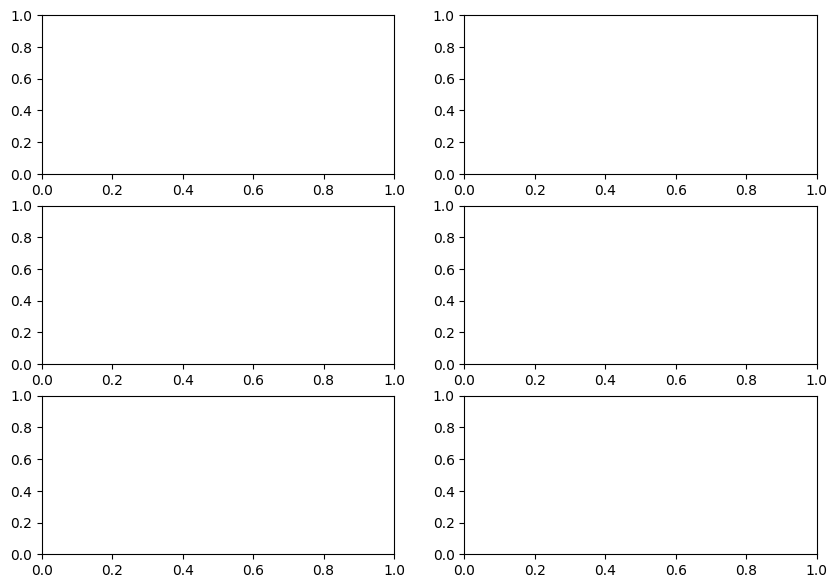

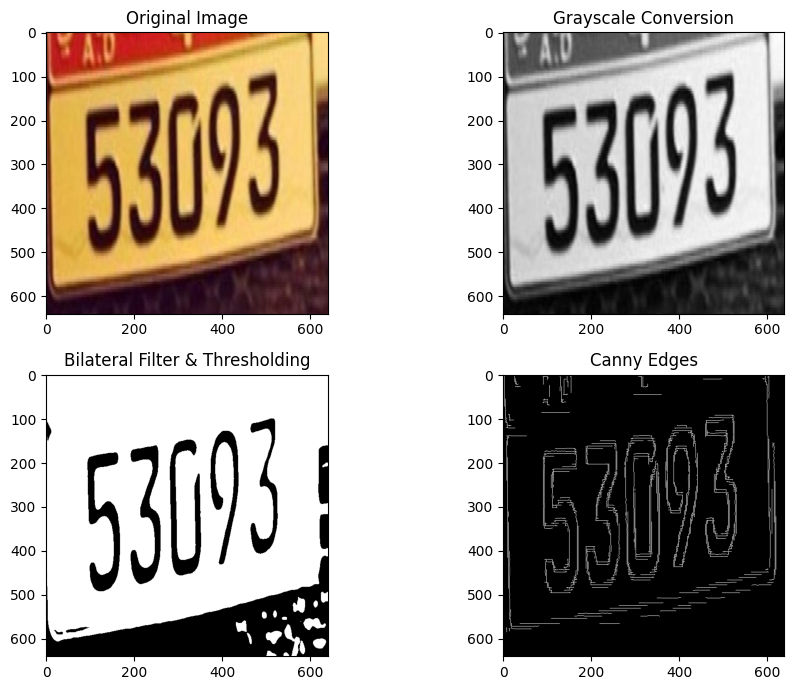

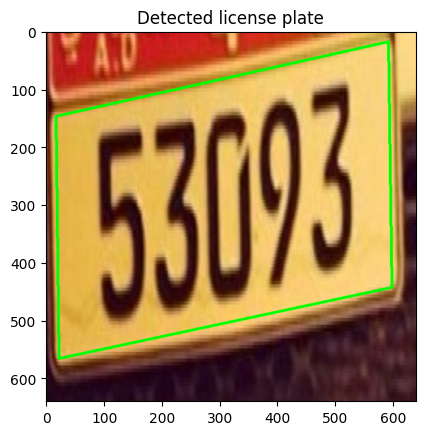

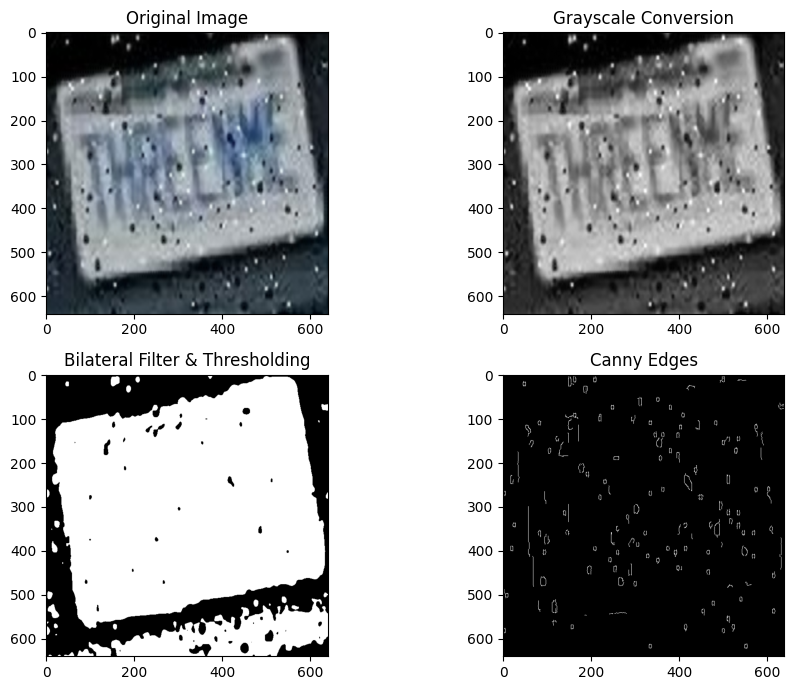

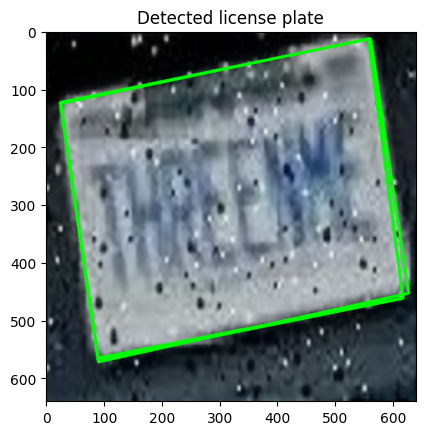

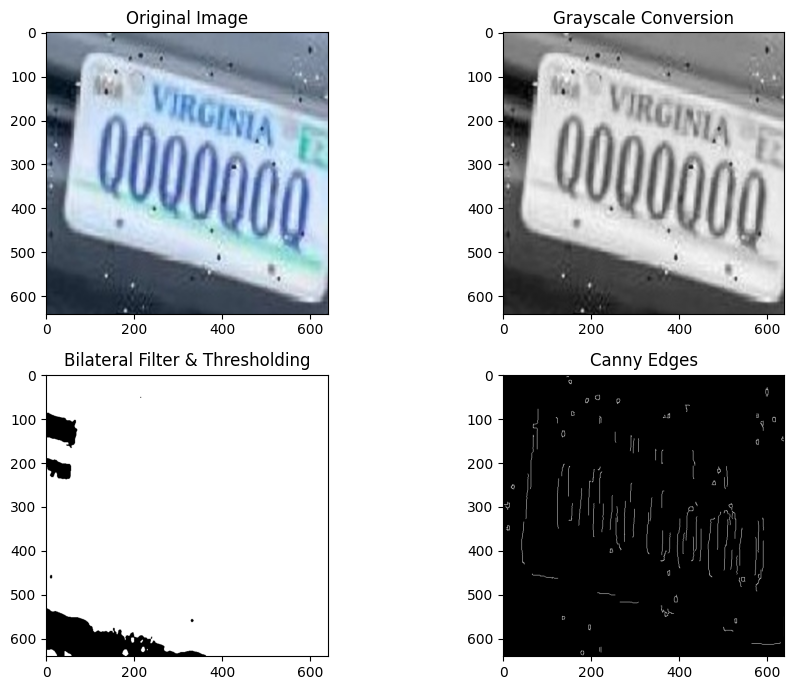

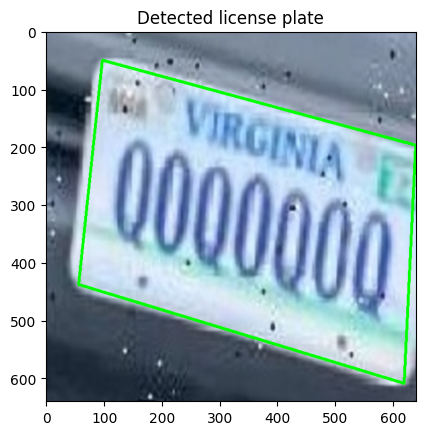

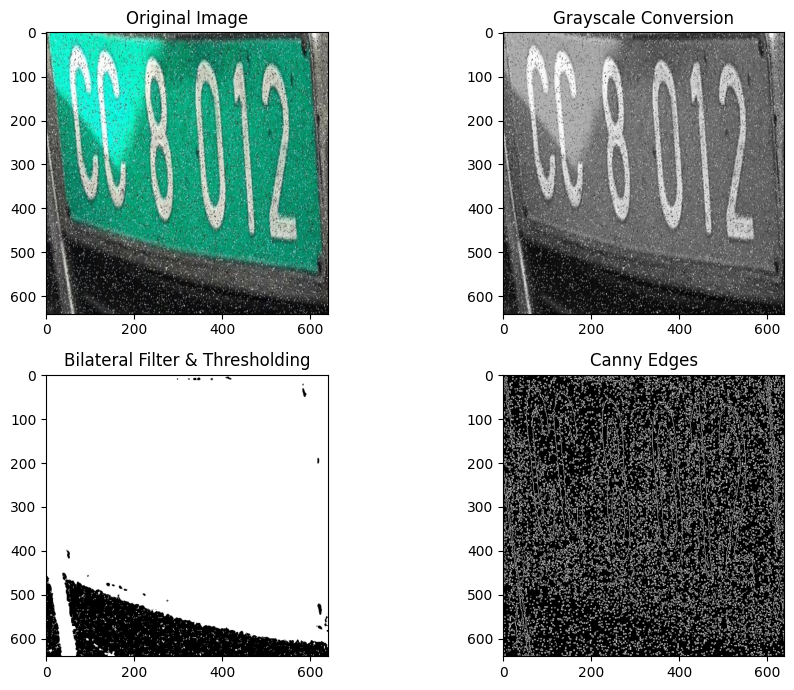

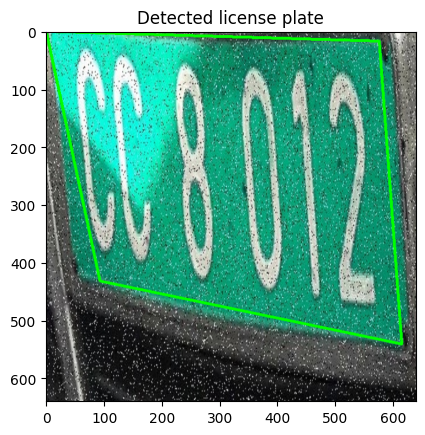

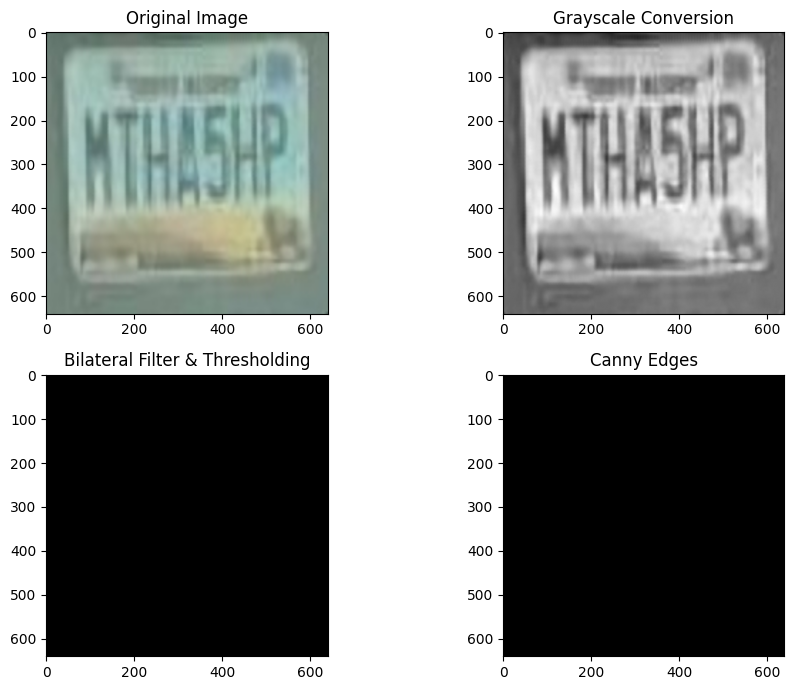

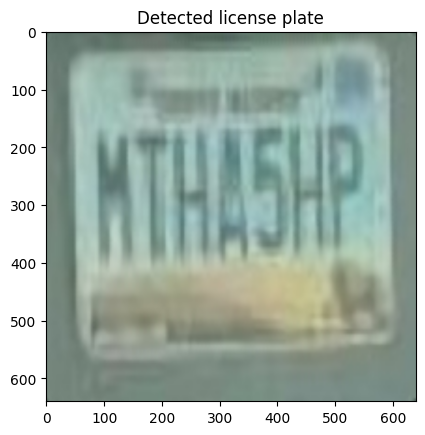

<Figure size 640x480 with 0 Axes>

In [22]:
cropped_license_plate_with_tilt = []
cropped_license_plate_with_tilt.append("D:\\Programming\\COEN490\\testing_area\\cropped_outputs\\session_number_1\\bc8c06d421ae5d3c_jpg.rf.629d847517f89e6d4c38437a4d13020d_crop_1.jpg")
cropped_license_plate_with_tilt.append("D:\\Programming\\COEN490\\testing_area\\cropped_outputs\\session_number_1\\wqbii1d0wiha1_jpg.rf.443d522ad0adf93a612fc58cba80ba84_crop_1.jpg")
cropped_license_plate_with_tilt.append("D:\\Programming\\COEN490\\testing_area\\cropped_outputs\\session_number_1\\WhatsApp-Image-2023-02-05-at-11-35-20-AM_jpeg_jpg.rf.a915d33a3b4e80580c7fc75cd4ccfbeb_crop_1.jpg")
cropped_license_plate_with_tilt.append("D:\\Programming\\COEN490\\testing_area\\cropped_outputs\\session_number_1\\spanje147_jpg.rf.a10dc6049812957c71fe9af30e8c755c_crop_1.jpg")
cropped_license_plate_with_tilt.append("D:\Programming\COEN490\\testing_area\cropped_outputs\session_number_1\qp3ab0qrdbga1_jpg.rf.45a424848f0e47ea1ef9ee4cd68a9116_crop_1.jpg")

fig, ax = plt.subplots(3, 2, figsize=(10,7))

for i, LP in enumerate(cropped_license_plate_with_tilt):
    image,_ = generate_contours(LP)

    # Plot the results
    ax[i//2,i%2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i//2,i%2].set_title(f'License Plate {i+1}')

    

plt.tight_layout()
plt.show()

## Issues with contour detection
As you can see above, the cropped images need to

- [ ] Have their edges visible
- [ ] Need to be fully contained within the image
- [ ] Need to have high enough resolution, with low blur

In order to improve the performance, several different thresholds were used to detect the corners of the license plates. 

<u>Trick to improve the performance</u>


### The next step would be to perform a homographic transform to straighten the License Plates.
----

In [5]:
def restructure_array(arr):
    """
    Takes an indivitual set of points and returns the correct format required for the rectangle detector
    """
    return [point[0].tolist() for point in arr]

def order_points(pts):
    """
    Orders a list of four points in the following order:
    top-left, top-right, bottom-right, bottom-left.
    """
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")
    
    # The top-left point will have the smallest sum,
    # the bottom-right will have the largest sum.
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # The top-right point will have the smallest difference,
    # the bottom-left will have the largest difference.
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def straighten_image(src_pts, image):
    """
    Last step: Performing a Homography Transform
    """
    # Get the size of the output image
    height, width = 400, 794  # Set the desired output size

    src_pts = np.float32(restructure_array(src_pts))
    src_pts = order_points(src_pts)
    # src_pts =  np.float32([point[:2] for point in src_pts]) # Convert to NumPy array
    print(src_pts)
    # Define four destination points (where the corners should be mapped)
    dst_pts = np.float32([
        [0, 0],           # top-left
        [width, 0],       # top-right
        [width, height],  # bottom-right
        [0, height]       # bottom-left
    ])
    
    # Compute the homography matrix
    H, _ = cv2.findHomography(src_pts, dst_pts)
    
    
    # Apply perspective transformation (warp the image)
    warped_image = cv2.warpPerspective(image, H, (width, height))
    return warped_image

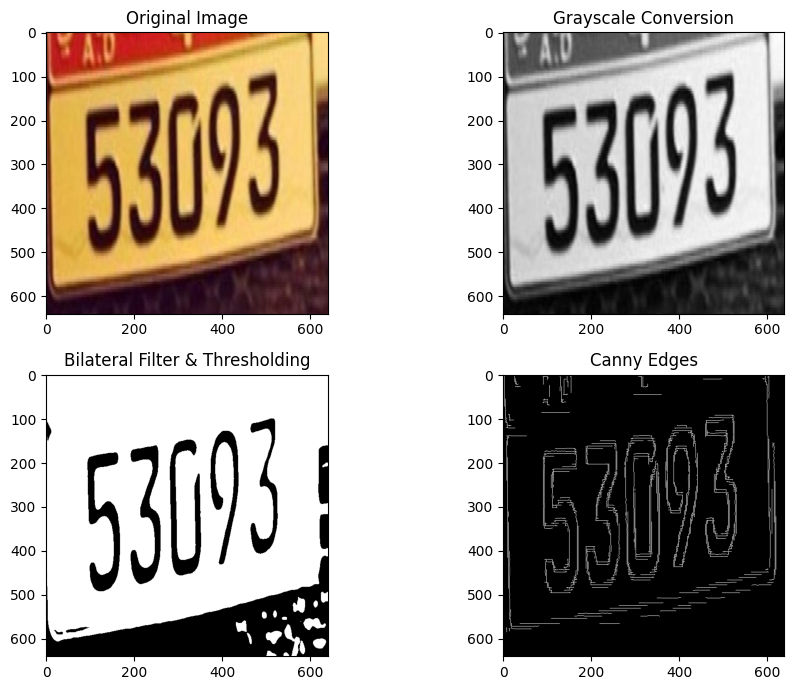

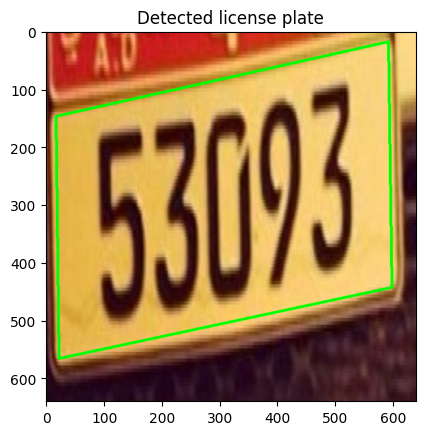

[[         17         147]
 [        592          18]
 [        598         443]
 [         22         566]]


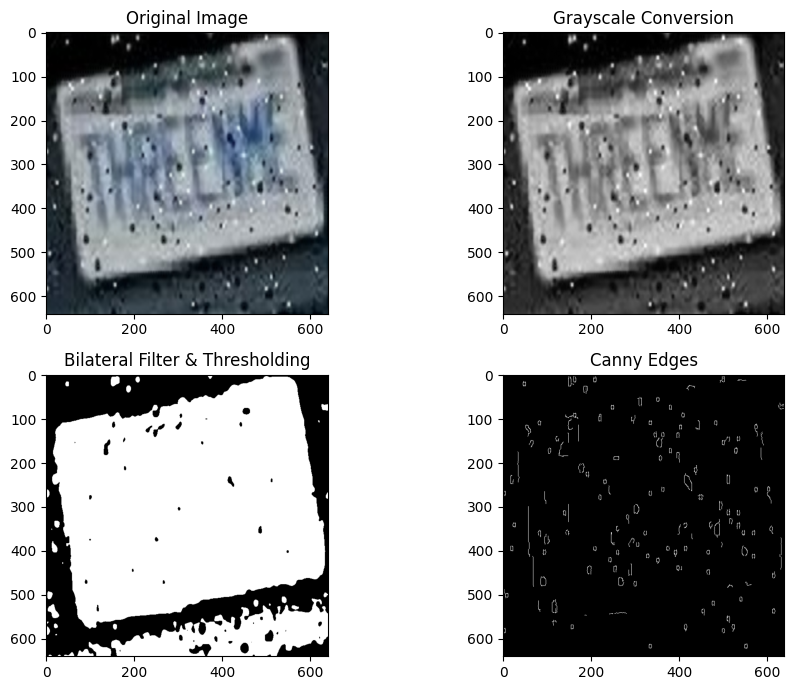

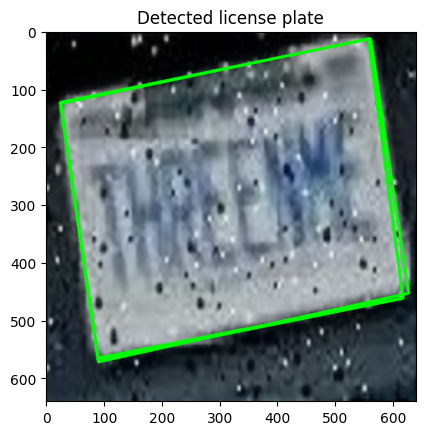

[[         24         123]
 [        561          13]
 [        627         453]
 [         90         572]]
[[         25         123]
 [        559          13]
 [        617         462]
 [         90         568]]
[[         25         125]
 [        557          13]
 [        617         461]
 [         90         565]]


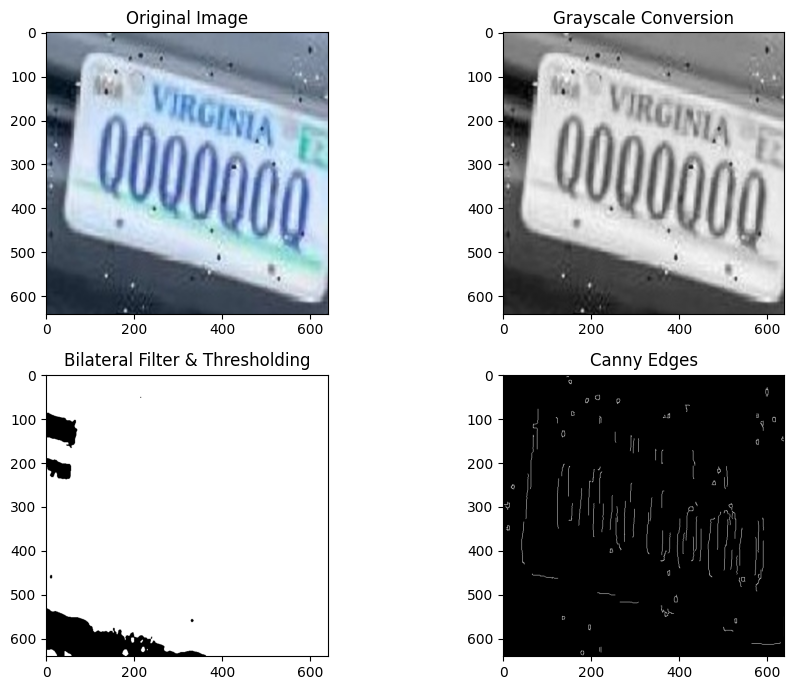

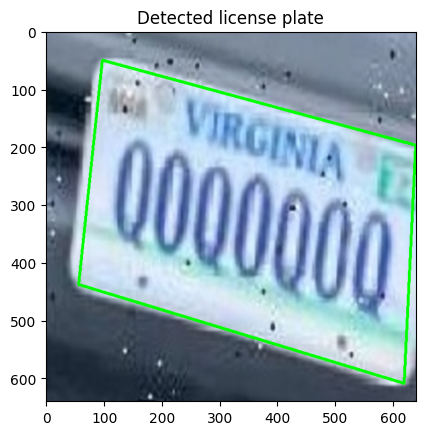

[[         97          50]
 [        639         197]
 [        619         609]
 [         56         438]]


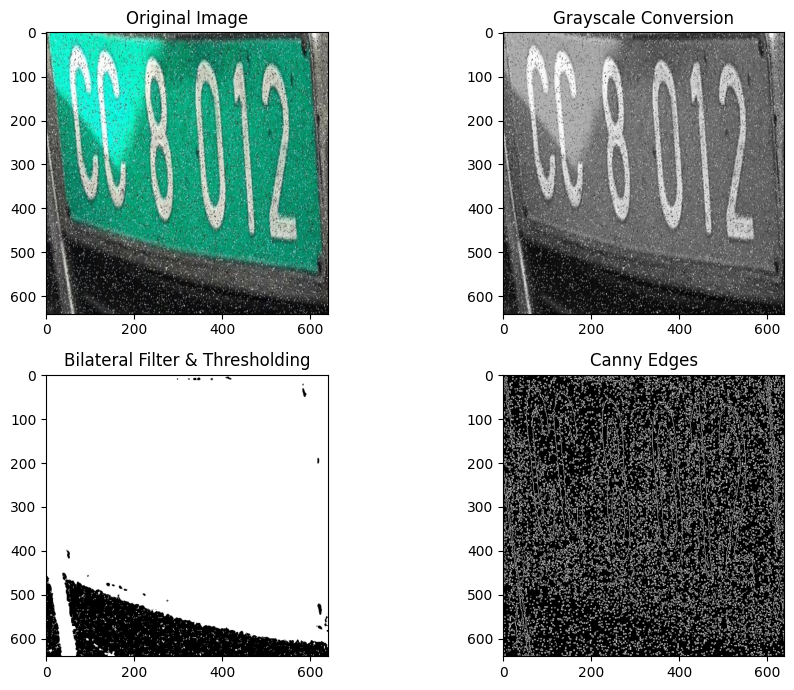

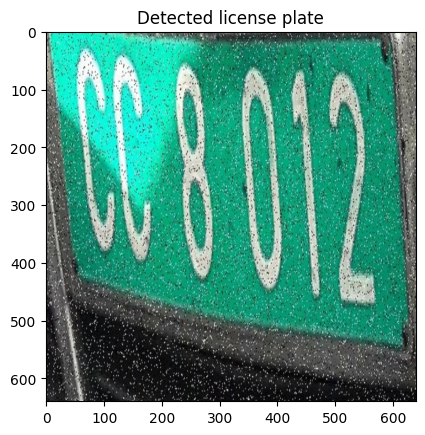

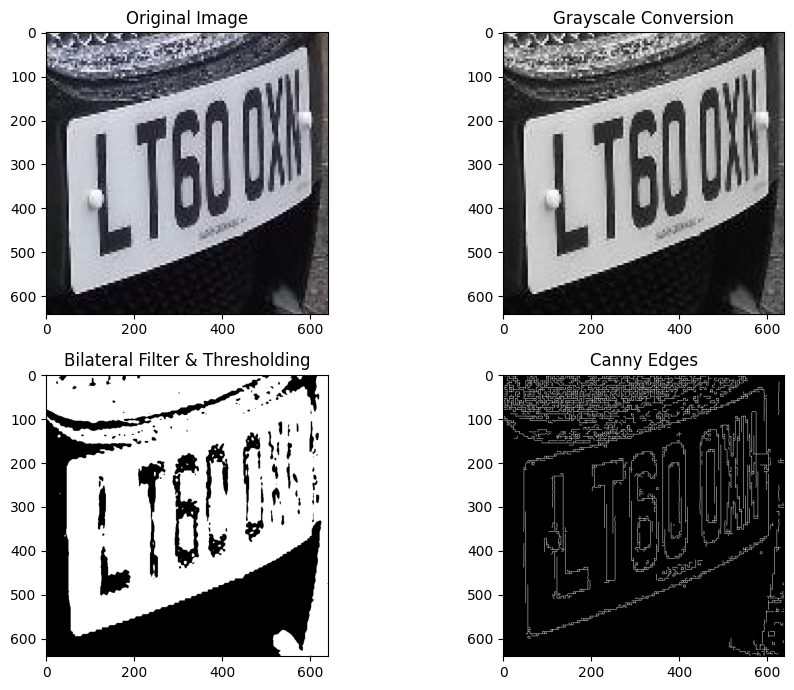

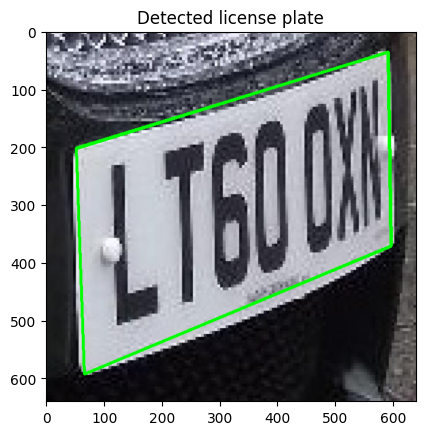

[[         52         202]
 [        592          36]
 [        597         371]
 [         66         593]]
[[         52         203]
 [        591          36]
 [        596         372]
 [         66         593]]


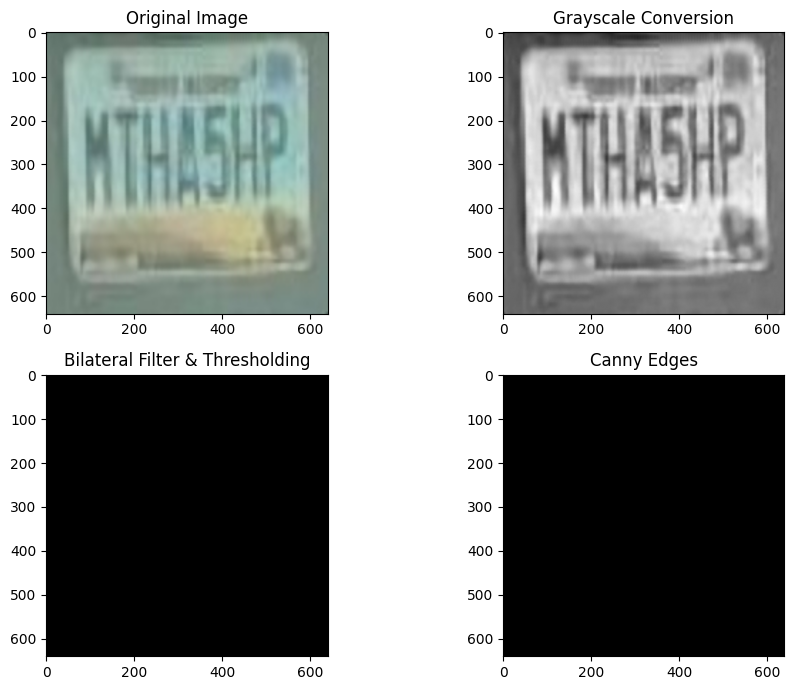

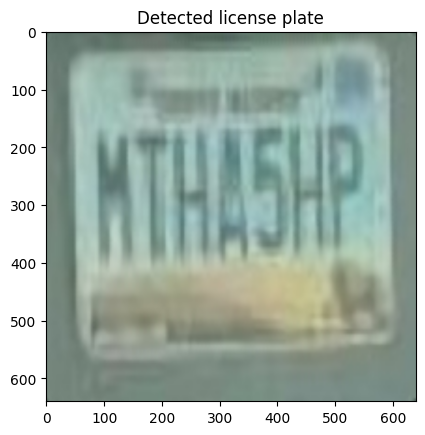

In [80]:
for i, LP in enumerate(cropped_license_plate_with_tilt):
    imagi, contours = generate_contours(LP)
    if contours is not None:
        for cnt in contours:
            imooge = straighten_image( cnt, imagi)
            cv2.imwrite(f"rectified_outputs\\rectified_plate_{i}.jpg", imooge)

# Final Output format after rectification

| Output Format | Dimensions |
|--------------|------------|
| Width        | 794 px     |
| Height       | 400 px     |

The `straighten_img` function takes in src_pts which represent the four edges of the detected contour and then use a homographic transform to transform the ROI to the desired dimensions we require.

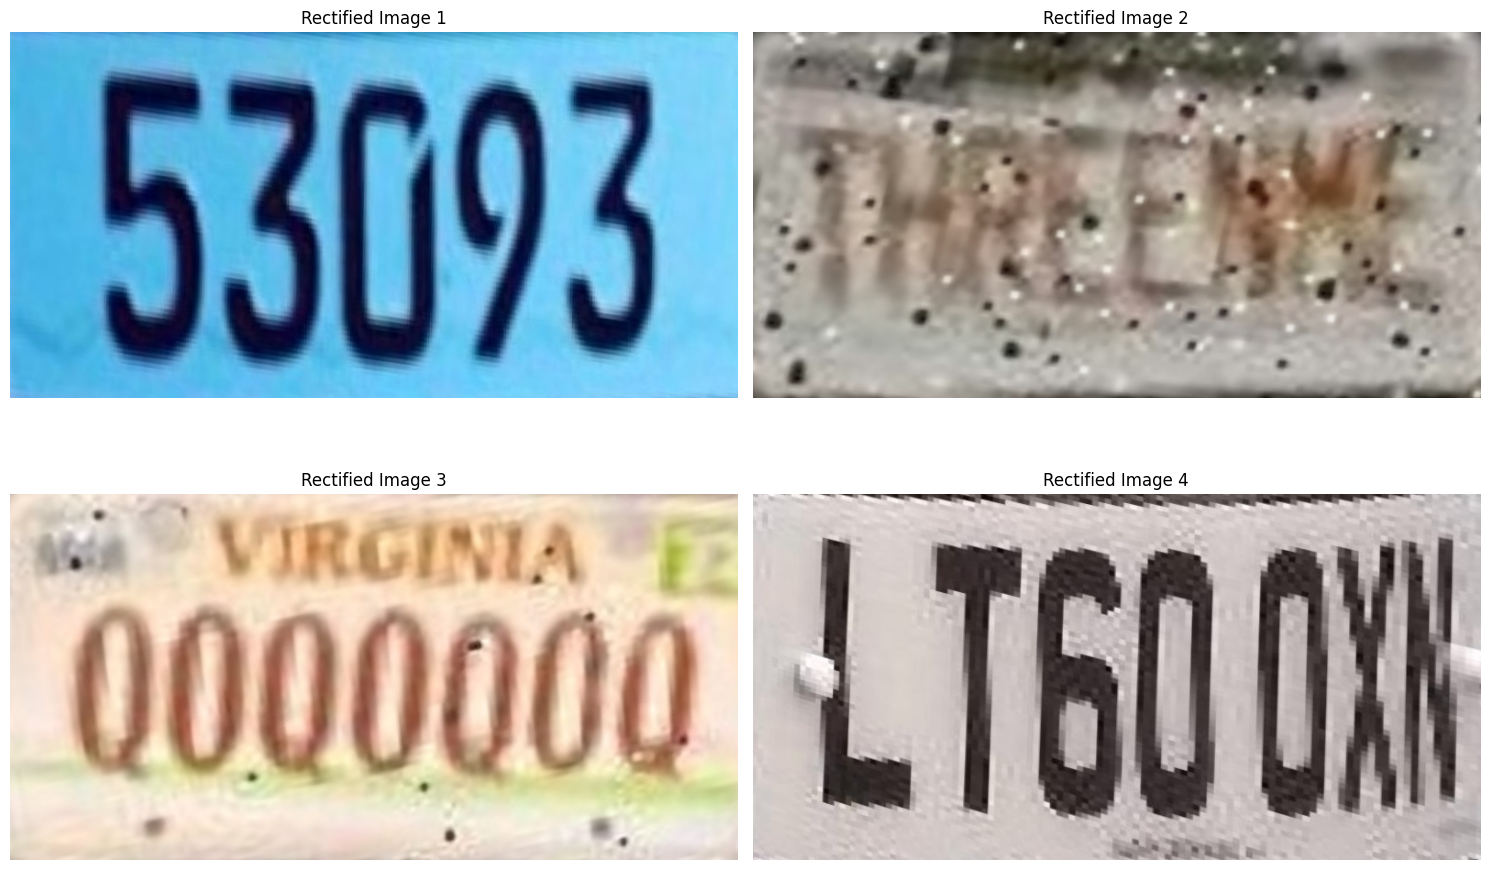

In [81]:
# Get list of rectified images
rectified_dir = 'rectified_outputs'
image_files = [f for f in os.listdir(rectified_dir) if f.endswith('.jpg')]

# Calculate number of rows needed (2 images per row)
n_images = len(image_files)
n_rows = (n_images + 1) // 2  # Round up division by 2

# Create subplot grid
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Plot each image
for i, img_file in enumerate(image_files):
    # Read image
    img_path = os.path.join(rectified_dir, img_file)
    img = cv2.imread(img_path)
    
    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot in appropriate subplot
    row = i // 2
    col = i % 2
    axes[row, col].imshow(img_rgb)
    axes[row, col].set_title(f'Rectified Image {i+1}')
    axes[row, col].axis('off')

# Hide empty subplots if odd number of images
if n_images % 2 == 1:
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.show()

In [23]:
def rectify_images(input_dir, session_number, output_dir='rectified_outputs'):
    """
    Rectify and crop license plates from images in multiple input directories.
    """
    # Create the output directory if it does not exist
    output_dir = os.path.join(output_dir, f"session_number_{session_number}")
    os.makedirs(output_dir, exist_ok=True)

    # Get list of image files in input directory
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(valid_extensions)]
    
    for image_file in image_files:
        # Construct full image path
        image_path = os.path.join(input_dir, image_file)
        
        try:
            # Process single image
            imagi, contours = generate_contours(image_path, True)
            if contours is not None:
                for cnt in contours:
                    imooge = straighten_image(cnt, imagi)
                    output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_rectified.jpg')
                    cv2.imwrite(output_path, imooge)
                    print(f"Processed: {image_file}")
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue


In [ ]:

# Usage
cropped_images_dir = r"D:\Programming\COEN490\testing_area\cropped_outputs\session_number_1"
rectify_images(cropped_images_dir, 1)

[[         49          65]
 [        554          63]
 [        601         552]
 [         87         567]]
Processed: 00125d8d-09b8-4a6e-9d2f-e2c240d22b38_jpg.rf.967ffa6bab1757abc96b0e90b6843366_crop_1.jpg
[[         70         154]
 [        639         104]
 [        639         582]
 [          0         639]]
Processed: 00239f47-3dc7-4ddd-9528-17b570276d83_jpg.rf.05048e5f74930ea50bfeb6282486c936_crop_1.jpg
[[         95         149]
 [        526         109]
 [        556         482]
 [         96         523]]
Processed: 00239f47-3dc7-4ddd-9528-17b570276d83_jpg.rf.05048e5f74930ea50bfeb6282486c936_crop_1.jpg
[[         92         163]
 [        522         108]
 [        558         477]
 [        129         531]]
Processed: 00239f47-3dc7-4ddd-9528-17b570276d83_jpg.rf.05048e5f74930ea50bfeb6282486c936_crop_1.jpg
[[         93         165]
 [        520         110]
 [        557         476]
 [        132         531]]
Processed: 00239f47-3dc7-4ddd-9528-17b570276d83_jpg.rf.0504

C:\Users\zhedt\AppData\Local\Temp\ipykernel_28016\2934705048.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 2, figsize=(10,7))


[[         62          20]
 [        578          50]
 [        584         513]
 [         64         484]]
Processed: 006ac91c-3d2a-4985-9fae-ed3f545f994f_jpg.rf.0206707944986089ef9631e6f8412fe5_crop_1.jpg
[[         63          18]
 [        580          51]
 [        583         515]
 [         66         486]]
Processed: 006ac91c-3d2a-4985-9fae-ed3f545f994f_jpg.rf.0206707944986089ef9631e6f8412fe5_crop_1.jpg
[[         58          47]
 [        580          80]
 [        583         551]
 [         59         519]]
Processed: 006ac91c-3d2a-4985-9fae-ed3f545f994f_jpg.rf.18f33444dd845a4c1607cce3e263b42e_crop_1.jpg
[[         58          45]
 [        583          81]
 [        586         549]
 [         61         522]]
Processed: 006ac91c-3d2a-4985-9fae-ed3f545f994f_jpg.rf.18f33444dd845a4c1607cce3e263b42e_crop_1.jpg
[[         55          46]
 [        585          81]
 [        582         556]
 [         60         523]]
Processed: 006ac91c-3d2a-4985-9fae-ed3f545f994f_jpg.rf.18f3

KeyboardInterrupt: 

# Step 3 Segmentation
---

Segmentation is done with the data that Rihaz labelled. 
In order to increase performance, train YOLO with minimum amount frozen layers and the correct size of the input images specified.
Train for longer epochs as there is a considerable decrease in errors.
The performance might also be shit because the sizes the model trained on is 224x128 whereas the input sizes are 794x400. <u>This was a mistake, fixing this may greatly improved model performance</u> 

Three metrics to look out for, 
<u>Three key metrics to monitor during YOLO training:</u>
 | Metric | Description |
 |--------|-------------|
 | Box Loss | Measures how well the model predicts bounding box coordinates (x,y,w,h). Lower values indicate better localization accuracy |
 | DFL Loss (Distribution Focal Loss) | Measures quality of predicted probability distributions for object classification. Lower values mean better class confidence |
 | Cls Loss (Classification Loss) | Measures accuracy of class predictions. Lower values indicate better object classification performance |


In [11]:
def crop_image_with_model(model_path, input_dir, session_number, output_dir='segmentation_ouputs'):
    """
    Crops license plates from images using a YOLOv8 model.
    
    Parameters:
        model_path (str): Path to the trained YOLOv8 model weights (.pt file)
        input_dir (str): Directory containing images to process 
        session_number (int): Session identifier number
        output_dir (str): Output directory for cropped plates (default: 'segmentation_outputs')
    
    Notes:
        - Uses YOLOv8n model trained on license plate detection
        - Handles standard plates, partially obstructed plates, and plates without vehicle
        - Input images should be 640x480 or 640x640 resolution
        - Supported formats: .jpg, .jpeg, .png, .bmp
        - Model uses 0.25 confidence threshold and 0.45 IOU threshold
        - Cropped plates are saved to session-specific subdirectories
    """
    # Create the output directory if it does not exist
    output_dir = os.path.join(output_dir, f"session_number_{session_number}")
    os.makedirs(output_dir, exist_ok=True)
    # Load model
    model = YOLO(model_path)

    # Get list of image files in input directory
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(valid_extensions)]
    
    for image_file in image_files:
        # Construct full image path
        image_path = os.path.join(input_dir, image_file)
        
        # Read the image
        image = cv2.imread(image_path)
        
        # Run inference on the image
        results = model.predict(source=image_path) # Optional: When you improve the model,Set IoU threshold of 45% or 60%
        
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            labels = result.boxes.cls.cpu().numpy()

            for idx, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cropped_image = image[y1-20:y2+20, x1-20:x2+20]
                # Create output path with filename
                output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_crop_{labels[idx]}.jpg')
                cv2.imwrite(output_path, cropped_image)
                print(f'Saved cropped image to {output_path}')

In [12]:
seg_best_model = "D:\Programming\COEN490\\testing_area\\best_segmentation_better.pt"
rectified_img_dir = "D:\Programming\COEN490\\testing_area\\rectified_outputs\\session_number_1"

crop_image_with_model(seg_best_model, rectified_img_dir, 1)


image 1/1 D:\Programming\COEN490\testing_area\rectified_outputs\session_number_1\00125d8d-09b8-4a6e-9d2f-e2c240d22b38_jpg.rf.967ffa6bab1757abc96b0e90b6843366_crop_1_rectified.jpg: 128x224 1 lp_1, 1 lp_2, 1 lp_3, 1 lp_4, 1 lp_5, 1 lp_6, 2 lp_7s, 23.1ms
Speed: 0.0ms preprocess, 23.1ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 224)
Saved cropped image to segmentation_ouputs\session_number_1\00125d8d-09b8-4a6e-9d2f-e2c240d22b38_jpg.rf.967ffa6bab1757abc96b0e90b6843366_crop_1_rectified_crop_1.0.jpg
Saved cropped image to segmentation_ouputs\session_number_1\00125d8d-09b8-4a6e-9d2f-e2c240d22b38_jpg.rf.967ffa6bab1757abc96b0e90b6843366_crop_1_rectified_crop_5.0.jpg
Saved cropped image to segmentation_ouputs\session_number_1\00125d8d-09b8-4a6e-9d2f-e2c240d22b38_jpg.rf.967ffa6bab1757abc96b0e90b6843366_crop_1_rectified_crop_2.0.jpg
Saved cropped image to segmentation_ouputs\session_number_1\00125d8d-09b8-4a6e-9d2f-e2c240d22b38_jpg.rf.967ffa6bab1757abc96b0e90b6843366_crop_1_recti

In [ ]:

model = YOLO(seg_best_model)

